# Pre-processing of GLAMOS MB data:

Does the pre-processing of the point MB measurements from GLAMOS (winter and summer).

# Point Mass Balance data:

## Setting up:

In [ ]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import config
from cmcrameri import cm
from calendar import monthrange

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = config.SwitzerlandConfig()

In [2]:
def plotHeatmap(df_):
    # Heatmap of mean mass balance per glacier:
    # Get the mean mass balance per glacier
    mean_mb_per_glacier = df_.groupby(
        ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
    mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] ==
                                              'annual']

    matrix = mean_mb_per_glacier.pivot(
        index='GLACIER', columns='YEAR',
        values='POINT_BALANCE').sort_values(by='GLACIER')

    # get elevation of glaciers:
    gl_per_el = df_.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
    gl_per_el = gl_per_el.sort_values(ascending=False)
    matrix = matrix.loc[gl_per_el.index]
    matrix = matrix.fillna(
        np.nan)  # Replace missing values with NaN; adjust as needed

    # make index categorical
    matrix.index = pd.Categorical(matrix.index,
                                  categories=matrix.index,
                                  ordered=True)
    fig = plt.figure(figsize=(20, 20))
    ax = plt.subplot(1, 1, 1)
    sns.heatmap(data=matrix,
                center=0,
                cmap=cm.vik_r,
                cbar_kws={'label': '[m w.e. $a^{-1}$]'},
                ax=ax)

In [ ]:
seed_all(cfg.seed) # TODO: remove and use random generator
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon

# For bars and lines:
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_1 = colors[0]
color_2 = '#c51b7d'

## Transform .dat files to .csv:

Transform the seasonal and winter PMB .dat files to .csv for simplicity. 

In [ ]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_mb_a, glamosfiles_mb_w = [], []
for file in os.listdir(path_PMB_GLAMOS_a_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_PMB_GLAMOS_a_raw, file)):
        glamosfiles_mb_a.append(file)

for file in os.listdir(path_PMB_GLAMOS_w_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_PMB_GLAMOS_w_raw, file)):
        glamosfiles_mb_w.append(file)

print('Examples of index stake raw files:\n', glamosfiles_mb_a[:5])

# Transform all files to csv
RUN = False
if RUN:
    emptyfolder(path_PMB_GLAMOS_csv_a)
    emptyfolder(path_PMB_GLAMOS_csv_w)
    for file in glamosfiles_mb_a:
        fileName = re.split('.dat', file)[0]
        processDatFile(fileName, path_PMB_GLAMOS_a_raw, path_PMB_GLAMOS_csv_a)

    for file in glamosfiles_mb_w:
        fileName = re.split('.dat', file)[0]
        processDatFile(fileName, path_PMB_GLAMOS_w_raw, path_PMB_GLAMOS_csv_w)

    # Separate clariden into clariden II and III
    fileName = 'clariden_annual.csv'
    clariden_csv_a = pd.read_csv(path_PMB_GLAMOS_csv_a + fileName,
                                 sep=',',
                                 header=0,
                                 encoding='latin-1')
    clariden_csv_a[clariden_csv_a['# name'] == 'L'].to_csv(
        path_PMB_GLAMOS_csv_a + 'claridenL_annual.csv', index=False)
    clariden_csv_a[clariden_csv_a['# name'] == 'U'].to_csv(
        path_PMB_GLAMOS_csv_a + 'claridenU_annual.csv', index=False)

    fileName = 'clariden_winter.csv'
    clariden_csv_w = pd.read_csv(path_PMB_GLAMOS_csv_w + fileName,
                                 sep=',',
                                 header=0,
                                 encoding='latin-1')
    clariden_csv_w[clariden_csv_w['# name'] == 'L'].to_csv(
        path_PMB_GLAMOS_csv_w + 'claridenL_winter.csv', index=False)
    clariden_csv_w[clariden_csv_w['# name'] == 'U'].to_csv(
        path_PMB_GLAMOS_csv_w + 'claridenU_winter.csv', index=False)

    os.remove(path_PMB_GLAMOS_csv_a + 'clariden_annual.csv')
    os.remove(path_PMB_GLAMOS_csv_w + 'clariden_winter.csv')

# Example:
fileName = 'aletsch_annual.csv'
aletsch_csv = pd.read_csv(path_PMB_GLAMOS_csv_a + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

##  Assemble measurement periods:
### Annual measurements: 
Process annual measurements and put all stakes into one csv file

In [ ]:
# List to collect processed DataFrames
df_list = []

# Process files
for file in tqdm(os.listdir(path_PMB_GLAMOS_csv_a), desc='Annual stakes'):
    fileName = re.split('.csv', file)[0]
    glacierName = re.split('_', fileName)[0]

    # Read CSV
    df = pd.read_csv(os.path.join(path_PMB_GLAMOS_csv_a, file),
                     sep=',',
                     header=0,
                     encoding='latin-1')
    df['glacier'] = glacierName
    df['period'] = 'annual'

    # Transform dates
    df = transformDates(df)

    # Drop duplicates early
    df = df.drop_duplicates()

    # Transform coordinates (from LV03 to WGS84)
    df = LV03toWGS84(df)

    # Append processed DataFrame to the list
    df_list.append(df)

# Concatenate all processed DataFrames
df_annual_raw = pd.concat(df_list, ignore_index=True)

# Process YEAR column and filter by year
df_annual_raw['YEAR'] = pd.to_datetime(df_annual_raw['date1']).dt.year
df_annual_raw = df_annual_raw[df_annual_raw['YEAR'] >= 1950]

# Rename and reorder columns for WGMS format
columns_mapping = {
    '# name': 'POINT_ID',
    'lat': 'POINT_LAT',
    'lon': 'POINT_LON',
    'height': 'POINT_ELEVATION',
    'date0': 'FROM_DATE',
    'date1': 'TO_DATE',
    'mb_we': 'POINT_BALANCE',
    'glacier': 'GLACIER',
    'period': 'PERIOD'
}
df_annual_raw.rename(columns=columns_mapping, inplace=True)

columns_order = [
    'YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
    'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'date_fix0',
    'date_fix1', 'time0', 'time1', 'date_quality', 'position_quality',
    'mb_raw', 'density', 'density_quality', 'measurement_quality',
    'measurement_type', 'mb_error', 'reading_error', 'density_error',
    'error_evaluation_method', 'source'
]
df_annual_raw = df_annual_raw[columns_order]

# Remove rows with invalid year difference
valid_date_mask = (
    pd.to_datetime(df_annual_raw['TO_DATE'], format='%Y%m%d').dt.year -
    pd.to_datetime(df_annual_raw['FROM_DATE'], format='%Y%m%d').dt.year) == 1
df_annual_raw = df_annual_raw[valid_date_mask]

# Filter measurement type and quality
df_annual_raw = df_annual_raw[(df_annual_raw['measurement_type'] <= 2)
                              & (df_annual_raw['measurement_quality'] == 1)]

# Remove duplicates as a final step
df_annual_raw = df_annual_raw.drop_duplicates()

# Display the first two rows
df_annual_raw.head(2)

### Winter measurements:
For each point in annual meas., take winter meas that was taken closest:

In [ ]:
# Clear the output folder
emptyfolder(path_PMB_GLAMOS_csv_w_clean)

# Pre-filter glaciers with winter measurements
winter_glaciers = {
    re.split('_winter.csv', f)[0]
    for f in os.listdir(path_PMB_GLAMOS_csv_w)
}
annual_glaciers = set(df_annual_raw.GLACIER.unique())
glaciers_to_process = annual_glaciers.intersection(winter_glaciers)

# Process each glacier
for glacier in tqdm(glaciers_to_process,
                    desc='Processing Winter Glaciers',
                    leave=False):
    # Read winter measurements
    df_winter = pd.read_csv(os.path.join(path_PMB_GLAMOS_csv_w,
                                         f"{glacier}_winter.csv"),
                            sep=',',
                            header=0,
                            encoding='latin-1')
    df_winter['period'] = 'winter'
    df_winter['glacier'] = glacier

    # Transform dates and remove duplicates
    df_winter = transformDates(df_winter).drop_duplicates()

    # Convert coordinates to lat/lon
    df_winter = LV03toWGS84(df_winter)

    # Add YEAR column and filter to >= 1950
    df_winter['YEAR'] = pd.to_datetime(df_winter['date1']).dt.year
    df_winter = df_winter[df_winter['YEAR'] >= 1950]

    # Rename and reorder columns
    columns_mapping = {
        '# name': 'POINT_ID',
        'lat': 'POINT_LAT',
        'lon': 'POINT_LON',
        'height': 'POINT_ELEVATION',
        'date0': 'FROM_DATE',
        'date1': 'TO_DATE',
        'mb_we': 'POINT_BALANCE',
        'glacier': 'GLACIER',
        'period': 'PERIOD'
    }
    columns_order = [
        'YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
        'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'date_fix0',
        'date_fix1', 'time0', 'time1', 'date_quality', 'position_quality',
        'mb_raw', 'density', 'density_quality', 'measurement_quality',
        'measurement_type', 'mb_error', 'reading_error', 'density_error',
        'error_evaluation_method', 'source'
    ]
    df_winter.rename(columns=columns_mapping, inplace=True)
    df_winter = df_winter[columns_order]

    # Filter measurements by type and quality
    df_winter = df_winter[(df_winter['measurement_type'] <= 2)
                          & (df_winter['measurement_quality'] == 1)]

    # Save the processed DataFrame to a CSV file
    output_file = os.path.join(path_PMB_GLAMOS_csv_w_clean,
                               f"{glacier}_winter_all.csv")
    df_winter.to_csv(output_file, index=False)

# # Filter winter stakes to only those that are close to annual stakes:
# winter_indices = []
# # Iterate over all rows in annual stakes:
# for index in tqdm(range(
#         len(df_annual_raw[df_annual_raw.GLACIER == glacier])),
#                   desc='rows',
#                   leave=False,
#                   position=1):
#     pointA = df_annual_raw[df_annual_raw.GLACIER ==
#                            glacier].iloc[index]
#     yearA = pointA.YEAR

#     # Filter winter to same year as point:
#     df_winter_year = df_winter[df_winter.YEAR == yearA]

#     # If no winter measurement was taken that year:
#     if len(df_winter_year) == 0:
#         continue

#     # Calculate closest winter point to annual stake:
#     df_winter_year['point'] = [(x, y) for x, y in zip(
#         df_winter_year['POINT_LAT'], df_winter_year['POINT_LON'])]
#     pointA['point'] = (pointA.POINT_LAT, pointA.POINT_LON)
#     closest = closest_point(pointA['point'],
#                             list(df_winter_year['point']))

#     # Convert to LAEA Europe
#     x_laea, y_laea = latlon_to_laea(closest[0], closest[1])
#     x_laea_point, y_laea_point = latlon_to_laea(
#         pointA.POINT_LAT, pointA.POINT_LON)

#     # Calculate distance:
#     distance_m = np.sqrt((x_laea_point - x_laea)**2 +
#                          (y_laea_point - y_laea)**2)

#     # Only keep winter stakes that are within 10m:
#     if distance_m > 10:
#         continue
#     else:
#         winter_indices.append(df_winter_year[df_winter_year['point'] ==
#                                              closest].index[0])

# # Save winter stakes filtered:
# df_winter_stakes = df_winter.iloc[winter_indices]
# df_winter_stakes.to_csv(path_PMB_GLAMOS_csv_w_clean + glacier +
#                         '_winter_close.csv')

### Assemble both periods:

In [ ]:
# Copy annual data
df_all_raw = df_annual_raw.copy()

# Collect all winter stake files
files_stakes = [
    f for f in os.listdir(path_PMB_GLAMOS_csv_w_clean) if '_winter_all' in f
]

# Combine winter stake data
winter_dataframes = []
for file in files_stakes:
    glacier_name = re.split('_', re.split('.csv', file)[0])[0]
    df_winter = pd.read_csv(os.path.join(path_PMB_GLAMOS_csv_w_clean, file),
                            sep=',',
                            header=0,
                            encoding='latin-1').drop(columns='Unnamed: 0',
                                                     errors='ignore')
    winter_dataframes.append(df_winter)

# Concatenate all winter dataframes with annual data
if winter_dataframes:
    df_all_raw = pd.concat([df_all_raw] + winter_dataframes, ignore_index=True)

# Reset index
df_all_raw.reset_index(drop=True, inplace=True)

# Correct winter date issues
df_all_raw = CleanWinterDates(df_all_raw)

# Display data stats
print('Number of winter and annual samples:', len(df_all_raw))
print('Number of winter samples:',
      len(df_all_raw[df_all_raw.PERIOD == 'winter']))
print('Number of annual samples:',
      len(df_all_raw[df_all_raw.PERIOD == 'annual']))

# Remove Pers glacier as it's part of the Morteratsch ensemble
df_all_raw = df_all_raw[df_all_raw.GLACIER != 'pers']

# Save all data to CSV
df_all_raw.to_csv(os.path.join(path_PMB_GLAMOS_csv, 'df_all_raw.csv'),
                  index=False)

# Save coordinates for all stakes
df_all_raw[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
            'PERIOD']].to_csv('coordinates_all.csv', index=False)

# Plot: Number of measurements per year
df_measurements_per_year = df_all_raw.groupby(['YEAR',
                                               'PERIOD']).size().unstack()
df_measurements_per_year.plot(kind='bar',
                              stacked=True,
                              figsize=(20, 5),
                              color=[color_1, color_2])
plt.title('Number of measurements per year for all glaciers')
plt.ylabel('Number of Measurements')
plt.xlabel('Year')
plt.legend(title='Period')
plt.tight_layout()
plt.show()

## Add RGIs Ids:

For each PMB measurement, we want to add the RGI ID (v6) of the shapefile it belongs to. 

In [ ]:
# take all winter and annual stakes (lots of snow probes)
df_all_raw = pd.read_csv(path_PMB_GLAMOS_csv + 'df_all_raw.csv',
                         sep=',',
                         header=0,
                         encoding='latin-1')

# Keep relevant WGMS columns:
df_pmb = df_all_raw[[
    'YEAR',
    'POINT_ID',
    'GLACIER',
    'FROM_DATE',
    'TO_DATE',
    'POINT_LAT',
    'POINT_LON',
    'POINT_ELEVATION',
    'POINT_BALANCE',
    'PERIOD',
]]

# Add RGIs:
# Specify the shape filename of the glaciers outline obtained from RGIv6
glacier_outline_fname = '../../../data/GLAMOS/RGI/nsidc0770_11.rgi60.CentralEurope/11_rgi60_CentralEurope.shp'

# Load the target data and the glacier outlines
glacier_outline = gpd.read_file(glacier_outline_fname)

# Add RGI IDs through intersection
df_pmb = mbm.data_processing.utils.get_rgi(data=df_pmb,
                                           glacier_outlines=glacier_outline)

# Handle unmatched points
no_match_df = df_pmb[df_pmb['RGIId'].isna()]
geometry = [
    Point(lon, lat)
    for lon, lat in zip(no_match_df["POINT_LON"], no_match_df["POINT_LAT"])
]
points_gdf = gpd.GeoDataFrame(no_match_df,
                              geometry=geometry,
                              crs=glacier_outline.crs)

for index in tqdm(no_match_df.index):
    point = points_gdf.loc[index]['geometry']
    polygon_index = glacier_outline.distance(point).sort_values().index[0]
    closest_rgi = glacier_outline.loc[polygon_index].RGIId
    df_pmb.at[index, 'RGIId'] = closest_rgi


In [ ]:
def check_multiple_rgi_ids(df):
    """
    Checks if any glacier is associated with more than one RGIId.
    """
    rgi_per_glacier = df.groupby('GLACIER')['RGIId'].nunique()
    glaciers_with_multiple_rgi = rgi_per_glacier[rgi_per_glacier > 1]
    if not glaciers_with_multiple_rgi.empty:
        print("Alert: The following glaciers have more than one RGIId:")
        print(glaciers_with_multiple_rgi)
    else:
        print("All glaciers are correctly associated with a single RGIId.")


def clean_rgi_ids(df):
    """
    Cleans and preprocesses RGI IDs for specific glaciers based on predefined rules.
    """
    corrections = {
        # Format: 'GLACIER': {'valid_rgi': 'RGI60-XX.XXXXX', 'action': 'drop|replace'}
        'albigna': {
            'valid_rgi': 'RGI60-11.02285',
            'action': 'drop'
        },
        'adler': {
            'valid_rgi': 'RGI60-11.02764',
            'action': 'drop'
        },
        'allalin': {
            'valid_rgi': 'RGI60-11.02704',
            'action': 'drop'
        },
        'basodino': {
            'valid_rgi': 'RGI60-11.01987',
            'action': 'drop'
        },
        'blauschnee': {
            'action': 'remove_glacier'
        },
        'corvatsch': {
            'valid_rgi': 'RGI60-11.01962',
            'action': 'drop'
        },
        'damma': {
            'valid_rgi': 'RGI60-11.01246',
            'action': 'drop'
        },
        'findelen': {
            'valid_rgi': 'RGI60-11.02773',
            'action': 'drop'
        },
        'hohlaub': {
            'valid_rgi': 'RGI60-11.02679',
            'action': 'drop'
        },
        'gries': {
            'valid_rgi': 'RGI60-11.01876',
            'action': 'drop'
        },
        'limmern': {
            'valid_rgi': 'RGI60-11.00918',
            'action': 'drop'
        },
        'ofental': {
            'action': 'remove_glacier'
        },
        'orny': {
            'valid_rgi': 'RGI60-11.02775',
            'action': 'replace'
        },
        'otemma': {
            'valid_rgi': 'RGI60-11.02801',
            'action': 'drop'
        },
        'plattalva': {
            'valid_rgi': 'RGI60-11.00892',
            'action': 'replace'
        },
        'plainemorte': {
            'valid_rgi': 'RGI60-11.02072',
            'action': 'drop'
        },
        'rhone': {
            'valid_rgi': 'RGI60-11.01238',
            'action': 'drop'
        },
        'sanktanna': {
            'valid_rgi': 'RGI60-11.01367',
            'action': 'drop'
        },
        'sexrouge': {
            'valid_rgi': 'RGI60-11.02244',
            'action': 'drop'
        },
        'silvretta': {
            'valid_rgi': 'RGI60-11.00804',
            'action': 'drop'
        },
        'tsanfleuron': {
            'valid_rgi': 'RGI60-11.02249',
            'action': 'drop'
        },
        'unteraar': {
            'action': 'remove_glacier'
        }
    }

    for glacier, details in corrections.items():
        if details['action'] == 'drop':
            df.drop(
                df[(df.GLACIER == glacier)
                   & (df.RGIId != details['valid_rgi'])].index,
                inplace=True,
            )
        elif details['action'] == 'replace':
            df.loc[df.GLACIER == glacier, 'RGIId'] = details['valid_rgi']
        elif details['action'] == 'remove_glacier':
            df.drop(df[df.GLACIER == glacier].index, inplace=True)

    return df


# Preprocess data
rgiids6 = df_pmb[['GLACIER', 'RGIId']].drop_duplicates()
print("RGIs before pre-processing:")
check_multiple_rgi_ids(rgiids6)

# Clean the data
df_pmb_clean = clean_rgi_ids(df_pmb.copy())
df_pmb_clean.reset_index(drop=True, inplace=True)

# Verify post-processing
rgiids6_clean = df_pmb_clean[['GLACIER', 'RGIId']].drop_duplicates()
print("RGIs after pre-processing:")
check_multiple_rgi_ids(rgiids6_clean)

## Cut from 1951:

In [ ]:
# Filter to start of MS data (1951) or ERA5-Land data (1950):
df_pmb_50s = df_pmb_clean[df_pmb_clean.YEAR > 1950].sort_values(
    by=['GLACIER', 'YEAR'], ascending=[True, True])

# Change from mm w.e. to m w.e.
df_pmb_50s['POINT_BALANCE'] = df_pmb_50s['POINT_BALANCE'] / 1000

# merge ClaridenL and ClaridenU into one glacier:
df_pmb_50s.loc[df_pmb_50s.GLACIER == 'claridenU', 'GLACIER'] = 'clariden'
df_pmb_50s.loc[df_pmb_50s.GLACIER == 'claridenL', 'GLACIER'] = 'clariden'

print('Number of winter and annual samples:', len(df_pmb_50s))
print('Number of annual samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s[df_pmb_50s.PERIOD == 'winter']))

# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s.groupby(['YEAR',
                    'PERIOD']).size().unstack().plot(kind='bar',
                                                     stacked=True,
                                                     color=[color_1, color_2],
                                                     ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1951')
plt.tight_layout()

plotHeatmap(df_pmb_50s)

### Merge stakes that are close: 
Especially with winter probes, a lot of measurements were done at the same place in the raw data and this leads to noise. We merge the stakes that are very close and keep the mean of the measurement.


In [ ]:
# clean df_pmb_50s
# Group similar stakes:
df_pmb_50s_clean = pd.DataFrame()
for gl in tqdm(df_pmb_50s.GLACIER.unique(), desc='glacier', position=0):
    print('----------------\n', gl, ':\n----------------')
    df_gl = df_pmb_50s[df_pmb_50s.GLACIER == gl]
    df_gl_cleaned = remove_close_points(df_gl)
    df_pmb_50s_clean = pd.concat([df_pmb_50s_clean, df_gl_cleaned])

# save to csv:
df_pmb_50s_clean.drop(['x', 'y'],
                      axis=1).to_csv(path_PMB_GLAMOS_csv + f'df_pmb_all.csv',
                                     index=False)

# save coordinates:
df_pmb_50s_clean[['GLACIER', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
                  'PERIOD']].to_csv(path_PMB_GLAMOS_csv +
                                    f'coordinate_50s_clean_all.csv')

plotHeatmap(df_pmb_50s_clean)

In [ ]:
# Number of measurements per year:
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax = axs.flatten()[0]
df_pmb_50s_clean.groupby(['YEAR', 'PERIOD'
                          ]).size().unstack().plot(kind='bar',
                                                   stacked=True,
                                                   color=[color_1, color_2],
                                                   ax=ax)
ax.set_title('Number of measurements per year for all glaciers')

ax = axs.flatten()[1]
num_gl = df_pmb_50s_clean.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', ax=ax)
ax.set_title('Number of total measurements per glacier since 1951')
plt.tight_layout()

In [ ]:
glacier_list = list(df_pmb_50s_clean.GLACIER.unique())
print('Number of glaciers:', len(glacier_list))
glacier_list.sort()
glacier_list

In [ ]:
# Number of measurements per glacier per year:
num_gl_yr = df_pmb_50s_clean.groupby(['GLACIER', 'YEAR', 'PERIOD'
                                      ]).size().unstack().reset_index()

num_gl_annual = df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual'].groupby(
    ['GLACIER']).size().sort_values()

# Plot one glacier per column:
big_gl = num_gl_annual[num_gl_annual > 250].index.sort_values()
num_glaciers = len(big_gl)
fig, ax = plt.subplots(num_glaciers, 1, figsize=(15, 5 * num_glaciers))
for i, gl in enumerate(big_gl):
    num_gl_yr[num_gl_yr.GLACIER == gl].plot(x='YEAR',
                                            kind='bar',
                                            stacked=True,
                                            ax=ax[i],
                                            title=gl)
    ax[i].set_ylabel('Number of measurements')
    ax[i].set_title

In [ ]:
print('Number of winter and annual samples:', len(df_pmb_50s_clean))
print('Number of annual samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_50s_clean[df_pmb_50s_clean.PERIOD == 'winter']))

## Add topographical information from OGGM:

In [ ]:
# Switch to oggm datapulling notebook:
df_pmb_topo = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')

# remove Pers
df_pmb_topo = df_pmb_topo[df_pmb_topo.GLACIER != 'pers']

print('Number of winter and annual samples:', len(df_pmb_topo))
print('Number of annual samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'winter']))

unique_years = df_pmb_topo.YEAR.unique()
unique_years.sort()
unique_years

## Give new stake IDs:
Give new stake IDs with glacier name and then a number according to the elevation. This is because accross glaciers some stakes have the same ID which is not practical.

In [ ]:
def check_point_ids_contain_glacier(dataframe):
    """
    Checks that each row's POINT_ID contains the name of the GLACIER.
    
    Parameters:
        dataframe (pd.DataFrame): A pandas DataFrame with columns "GLACIER" and "POINT_ID".
        
    Returns:
        bool: True if all rows satisfy the condition, False otherwise.
        pd.DataFrame: A DataFrame of rows where the condition is not met.
    """
    if 'GLACIER' not in dataframe.columns or 'POINT_ID' not in dataframe.columns:
        raise ValueError(
            "The dataframe must contain 'GLACIER' and 'POINT_ID' columns.")

    # Check condition
    invalid_rows = dataframe[~dataframe.apply(
        lambda row: row['GLACIER'] in row['POINT_ID'], axis=1)]

    # Report
    if invalid_rows.empty:
        print(
            "All POINT_IDs correctly contain their respective GLACIER names.")
        return True, None
    else:
        print(
            f"Found {len(invalid_rows)} rows where POINT_ID does not contain the GLACIER name."
        )
        return False, invalid_rows

In [ ]:
for glacierName in tqdm(df_pmb_topo.GLACIER.unique(), desc='glaciers'):
    gl_data = df_pmb_topo[df_pmb_topo.GLACIER == glacierName]
    stakeIDS = gl_data.groupby('POINT_ID')[[
        'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION'
    ]].mean()
    stakeIDS.reset_index(inplace=True)
    # Change the ID according to elevation
    new_ids = stakeIDS[['POINT_ID',
                        'POINT_ELEVATION']].sort_values(by='POINT_ELEVATION')
    new_ids['POINT_ID_new'] = [
        f'{glacierName}_{i}' for i in range(len(new_ids))
    ]
    for i, row in new_ids.iterrows():
        df_pmb_topo.loc[(df_pmb_topo.GLACIER == glacierName) &
                        (df_pmb_topo.POINT_ID == row.POINT_ID),
                        'POINT_ID'] = row.POINT_ID_new

# Check the condition
check_point_ids_contain_glacier(df_pmb_topo)
print('Number of winter and annual samples:', len(df_pmb_topo))
print('Number of annual samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'winter']))

# Save to csv:
df_pmb_topo.to_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv',
                   index=False)

# Histogram of mass balance
df_pmb_topo['POINT_BALANCE'].hist(bins=20)
plt.xlabel('Mass balance [m w.e.]')

# Glacier wide MB:

## Obs: no fixed dates, but using observed periods.

In [ ]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_smb = []
for file in os.listdir(path_SMB_GLAMOS_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_SMB_GLAMOS_raw,
                                   file)) and 'obs' in file:
        glamosfiles_smb.append(file)
print('Examples of index stake raw files:\n', glamosfiles_smb[:5])

# Transform all files to csv
RUN = True
if RUN:
    emptyfolder(path_SMB_GLAMOS_csv + 'obs/')
    for file in glamosfiles_smb:
        fileName = re.split('.dat', file)[0]
        processDatFileGLWMB(fileName, path_SMB_GLAMOS_raw,
                            path_SMB_GLAMOS_csv + 'obs/')

# Example:
fileName = 'aletsch_obs.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'obs/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

## Fix: with fixed periods (hydrological year).

In [ ]:
# Get all files with pmb (for winter and annual mb):
glamosfiles_smb = []
for file in os.listdir(path_SMB_GLAMOS_raw):
    # check if current path is a file
    if os.path.isfile(os.path.join(path_SMB_GLAMOS_raw,
                                   file)) and 'fix' in file:
        glamosfiles_smb.append(file)
print('Examples of index stake raw files:\n', glamosfiles_smb[:5])
# Transform all files to csv
RUN = True
if RUN:
    emptyfolder(path_SMB_GLAMOS_csv + 'fix/')
    for file in glamosfiles_smb:
        fileName = re.split('.dat', file)[0]
        processDatFileGLWMB(fileName, path_SMB_GLAMOS_raw,
                            path_SMB_GLAMOS_csv + 'fix/')

# Example:
fileName = 'aletsch_fix.csv'
aletsch_csv = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' + fileName,
                          sep=',',
                          header=0,
                          encoding='latin-1')
aletsch_csv.head(2)

# Potential incoming clear sky solar radiation:

Pre-process glamos data of Potential incoming clear sky solar radiation (pcsr) used as a topographical variable. One per day grid per glacier for one year only, depends on the glacier.

In [4]:
glDirect = os.listdir(path_pcsr + 'raw/')
glDirect.sort()  # Glaciers with data

# Read stakes data over all glaciers:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')

print('Number of glacier with clear sky radiation data:', len(glDirect))
glDirect

Number of glacier with clear sky radiation data: 33


['albigna',
 'aletsch',
 'allalin',
 'arolla',
 'basodino',
 'clariden',
 'corbassiere',
 'corvatsch',
 'findelen',
 'forno',
 'gietro',
 'gorner',
 'gries',
 'hohlaub',
 'joeri',
 'limmern',
 'morteratsch',
 'murtel',
 'oberaar',
 'otemma',
 'pers',
 'pizol',
 'plainemorte',
 'plattalva',
 'rhone',
 'schwarzbach',
 'schwarzberg',
 'sexrouge',
 'silvretta',
 'stanna',
 'taelliboden',
 'tortin',
 'tsanfleuron']

In [6]:
path_pcsr_save = path_pcsr + 'csv/'
empty = True
if empty:
    emptyfolder(path_pcsr_save)
else:
    glProcessed = [
        re.search(r"xr_direct_(.*)\.nc", f).group(1)
        for f in os.listdir(path_pcsr_save)
    ]
    glDirect = list(set(glDirect) - set(glProcessed))

for glacierName in tqdm(glDirect, desc='glaciers', position=0):
    print(glacierName)
    grid = os.listdir(path_pcsr + 'raw/' + glacierName)
    grid_year = int(re.findall(r'\d+', grid[0])[0])
    daily_grids = os.listdir(path_pcsr + 'raw/' + glacierName + '/' + grid[0])
    # Sort by day number from 001 to 365
    daily_grids.sort()
    grids = []
    for fileName in daily_grids:
        if 'grid' not in fileName:
            continue

        # Load daily grid file
        file_path = path_pcsr + 'raw/' + glacierName + '/' + grid[
            0] + '/' + fileName
        metadata, grid_data = load_grid_file(file_path)
        grids.append(grid_data)

    # Take monthly means:
    monthly_grids = []
    for i in range(12):
        num_days_month = monthrange(grid_year, i + 1)[1]
        monthly_grids.append(
            np.mean(np.stack(grids[i * num_days_month:(i + 1) *
                                   num_days_month],
                             axis=0),
                    axis=0))

    monthly_grids = np.array(monthly_grids)
    num_months = monthly_grids.shape[0]

    # Convert to xarray (CH coordinates)
    data_array = convert_to_xarray(monthly_grids, metadata, num_months)

    # Convert to WGS84 (lat/lon) coordinates
    data_array_transf = transform_xarray_coords_lv03_to_wgs84(data_array)

    # Save xarray
    if glacierName == 'findelen':
        data_array_transf.to_netcdf(path_pcsr_save +
                                    f'xr_direct_{glacierName}.nc')
        data_array_transf.to_netcdf(path_pcsr_save + f'xr_direct_adler.nc')
    elif glacierName == 'stanna':
        data_array_transf.to_netcdf(path_pcsr_save + f'xr_direct_sanktanna.nc')
    else:
        data_array_transf.to_netcdf(path_pcsr_save +
                                    f'xr_direct_{glacierName}.nc')

glaciers:   0%|          | 0/33 [00:00<?, ?it/s]

albigna
aletsch
allalin
arolla
basodino
clariden
corbassiere
corvatsch
findelen
forno
gietro
gorner
gries
hohlaub
joeri
limmern
morteratsch
murtel
oberaar
otemma
pers
pizol
plainemorte
plattalva
rhone
schwarzbach
schwarzberg
sexrouge
silvretta
stanna
taelliboden
tortin
tsanfleuron


Number of processed glaciers: 34


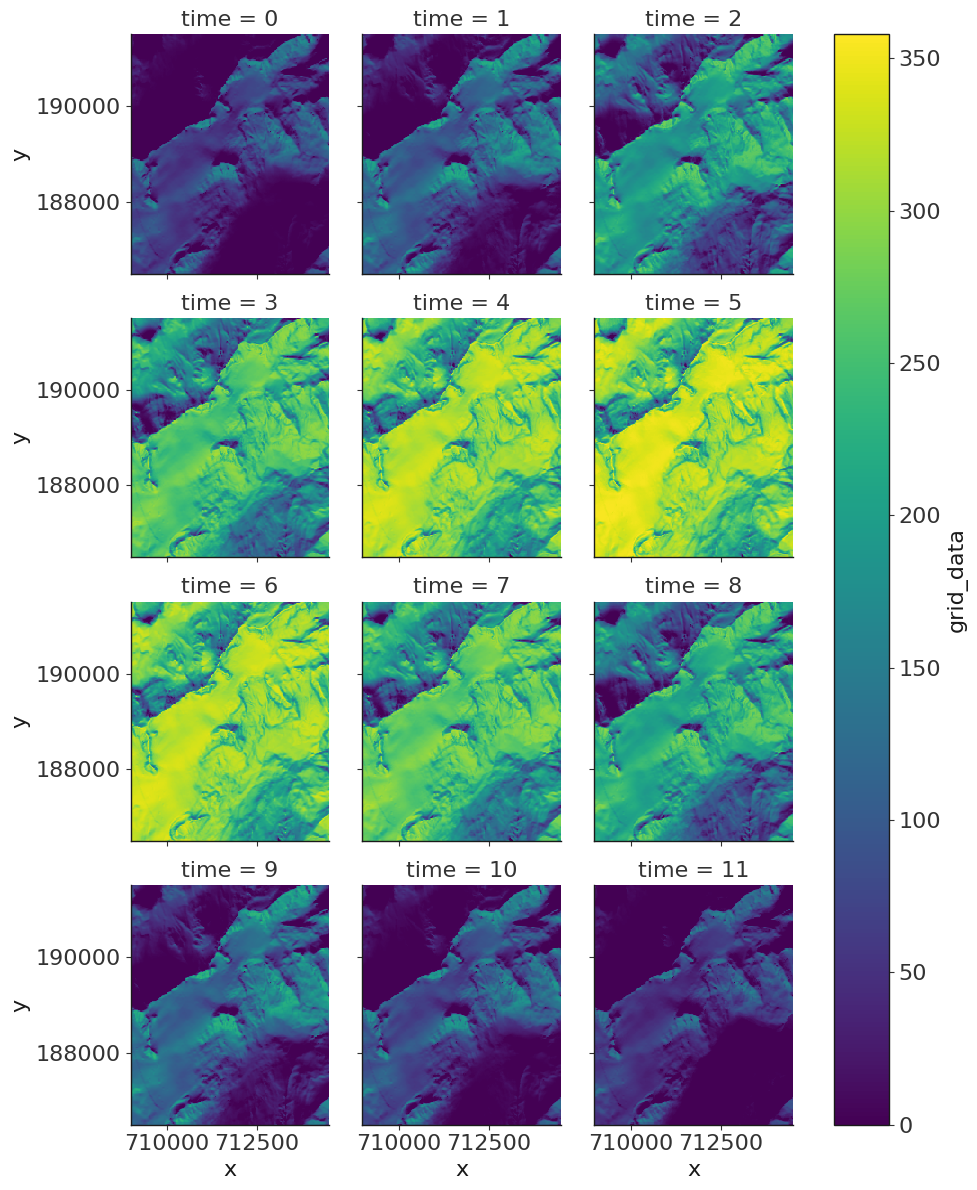

In [7]:
# Number of processed glaciers:
print('Number of processed glaciers:', len(os.listdir(path_pcsr_save)))

# read an plot one file
xr_file = xr.open_dataset(path_pcsr_save + 'xr_direct_clariden.nc')
xr_file['grid_data'].plot(x='x', y='y', col='time', col_wrap=3)